<a href="https://colab.research.google.com/github/jmende27/Softmax_Regression/blob/main/chapter_linear-networks/softmax-regression-concise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [65]:
!pip install d2l==0.17.0
!pip install -U mxnet-cu101==1.7.0


# Concise Implementation of Softmax Regression
:label:`sec_softmax_concise`



(**Just as high-level APIs**)
of deep learning frameworks
(**made it much easier to implement linear regression**)
in :numref:`sec_linear_concise`,
(**we will find it similarly**) (~~here~~) (or possibly more)
convenient for implementing classification models. Let us stick with the Fashion-MNIST dataset
and keep the batch size at 256 as in :numref:`sec_softmax_scratch`.


In [66]:
from mxnet import gluon, init, npx
from mxnet.gluon import nn
from d2l import mxnet as d2l

npx.set_np()

In [67]:
batch_size = 100
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

## Initializing Model Parameters

As mentioned in :numref:`sec_softmax`,
[**the output layer of softmax regression
is a fully-connected layer.**]
Therefore, to implement our model,
we just need to add one fully-connected layer
with 10 outputs to our `Sequential`.
Again, here, the `Sequential` is not really necessary,
but we might as well form the habit since it will be ubiquitous
when implementing deep models.
Again, we initialize the weights at random
with zero mean and standard deviation 0.01.


In [68]:
net = nn.Sequential()
net.add(nn.Dense(10))
net.initialize(init.Normal(sigma=0.01))

## Softmax Implementation Revisited
:label:`subsec_softmax-implementation-revisited`

In the previous example of :numref:`sec_softmax_scratch`,
we calculated our model's output
and then ran this output through the cross-entropy loss.
Mathematically, that is a perfectly reasonable thing to do.
However, from a computational perspective,
exponentiation can be a source of numerical stability issues.

Recall that the softmax function calculates
$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$,
where $\hat y_j$ is the $j^\mathrm{th}$ element of
the predicted probability distribution $\hat{\mathbf{y}}$
and $o_j$ is the $j^\mathrm{th}$ element of the logits
$\mathbf{o}$.
If some of the $o_k$ are very large (i.e., very positive),
then $\exp(o_k)$ might be larger than the largest number
we can have for certain data types (i.e., *overflow*).
This would make the denominator (and/or numerator) `inf` (infinity)
and we wind up encountering either 0, `inf`, or `nan` (not a number) for $\hat y_j$.
In these situations we do not get a well-defined
return value for cross-entropy.


One trick to get around this is to first subtract $\max(o_k)$
from all $o_k$ before proceeding with the softmax calculation.
You can see that this shifting of each $o_k$ by constant factor
does not change the return value of softmax:

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


After the subtraction and normalization step,
it might be possible that some $o_j - \max(o_k)$ have large negative values
and thus that the corresponding $\exp(o_j - \max(o_k))$ will take values close to zero.
These might be rounded to zero due to finite precision (i.e., *underflow*),
making $\hat y_j$ zero and giving us `-inf` for $\log(\hat y_j)$.
A few steps down the road in backpropagation,
we might find ourselves faced with a screenful
of the dreaded `nan` results.

Fortunately, we are saved by the fact that
even though we are computing exponential functions,
we ultimately intend to take their log
(when calculating the cross-entropy loss).
By combining these two operators
softmax and cross-entropy together,
we can escape the numerical stability issues
that might otherwise plague us during backpropagation.
As shown in the equation below, we avoid calculating $\exp(o_j - \max(o_k))$
and can use instead $o_j - \max(o_k)$ directly due to the canceling in $\log(\exp(\cdot))$:

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

We will want to keep the conventional softmax function handy
in case we ever want to evaluate the output probabilities by our model.
But instead of passing softmax probabilities into our new loss function,
we will just
[**pass the logits and compute the softmax and its log
all at once inside the cross-entropy loss function,**]
which does smart things like the ["LogSumExp trick"](https://en.wikipedia.org/wiki/LogSumExp).


In [69]:
loss = gluon.loss.SoftmaxCrossEntropyLoss()

## Optimization Algorithm

Here, we (**use minibatch stochastic gradient descent**)
with a learning rate of 0.1 as the optimization algorithm.
Note that this is the same as we applied in the linear regression example
and it illustrates the general applicability of the optimizers.


In [70]:
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})

## Training

Next we [**call the training function defined**] (~~earlier~~) in :numref:`sec_softmax_scratch` to train the model.


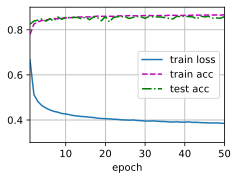

In [71]:
num_epochs = 50
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

As before, this algorithm converges to a solution
that achieves a decent accuracy,
albeit this time with fewer lines of code than before.


## Summary

* Using high-level APIs, we can implement softmax regression much more concisely.
* From a computational perspective, implementing softmax regression has intricacies. Note that in many cases, a deep learning framework takes additional precautions beyond these most well-known tricks to ensure numerical stability, saving us from even more pitfalls that we would encounter if we tried to code all of our models from scratch in practice.

## Exercises

1. Try adjusting the hyperparameters, such as the batch size, number of epochs, and learning rate, to see what the results are.
1. Increase the number of epochs for training. Why might the test accuracy decrease after a while? How could we fix this?


[Discussions](https://discuss.d2l.ai/t/52)
